这里讨论一些一直回避的问题，明显这种naive贝叶斯分类器并不能处理真正复杂的分布。这里讨论其表示的极限和修正方式。

In [1]:
import bayestorch as bt
from bayestorch import Parameter,Data,Variable,optimizing,vb,sampling,reset
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
#from bayestorch.data.battle import friend_point,enemy_point,battle_point
%matplotlib inline

In [2]:
def rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],
                     [np.sin(theta),np.cos(theta)]])



In [3]:
n_friend = 20
radius = np.random.random(n_friend)*0.5+2
radian = np.random.random(n_friend)*np.pi*2

friend_point = np.array([rotation_matrix(radian[i]) @ np.array([radius[i],0]) for i in range(n_friend)])

n_battle = 15
radius = np.random.random(n_battle)*1.0+2.5
radian = np.random.random(n_battle)*np.pi*2

battle_point = np.array([rotation_matrix(radian[i]) @ np.array([radius[i],0]) for i in range(n_battle)])


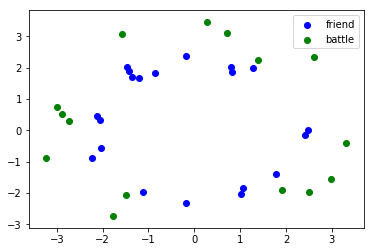

In [4]:
plt.scatter(friend_point[:,0], friend_point[:,1], label="friend", color="blue")
plt.scatter(battle_point[:,0], battle_point[:,1], label="battle", color='green')
plt.legend()
plt.show()

In [5]:
def equidistance_init(n, radius=3.0):
    theta = np.linspace(0,2*np.pi,n)
    return np.array([rotation_matrix(t) @ np.array([radius,0]) for t in theta])

In [6]:
n_enemy = 6

enemy_point = equidistance_init(6)

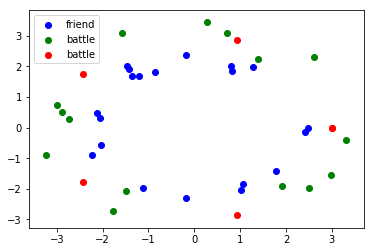

In [7]:
plt.scatter(friend_point[:,0], friend_point[:,1], label="friend", color="blue")
plt.scatter(battle_point[:,0], battle_point[:,1], label="battle", color='green')
plt.scatter(enemy_point[:,0],  enemy_point[:,1],  label="battle", color='red')
plt.legend()
plt.show()

In [8]:
X = np.vstack([friend_point, enemy_point])
Y = np.ones(X.shape[0],dtype=int)
Y[:friend_point.shape[0]] = 0


_logPC = np.log(np.array([np.sum(Y==0)/len(Y),np.sum(Y==1)/len(Y)])) #这个前面很多实验忘了在改数量时候更新这个，成了个不恰当的先验的效果


In [9]:
from bayestorch.distributions import norm_log_prob
from bayestorch.classifier import norm_naive_bayes_predict
from bayestorch.utils import GridSampler2d,cdist,soft_cut_ge,soft_cut_le

model = bt.core.current_model

In [10]:
# model
friend = Data(friend_point)
battle = Data(battle_point)
enemy = Parameter(enemy_point) # set real value as init value, though maybe a randomed init is more proper

logPC = Data(_logPC)

conflict_threshold = 0.2
distance_threshold = 1.0
tense = 10.0
alpha = 5.0
prior_threshold = 5.0
prior_tense = 5.0

def target():
    friend_enemy = torch.cat((friend, enemy),0)
    distance = cdist(battle, friend_enemy).min(dim=1)[0]
    

    mu = Variable(torch.zeros(2,2)) #目前外层还有个同名的numpy.array mu,sd变量不要搞混了
    sd = Variable(torch.zeros(2,2))
    
    mu[0,:] = friend.mean(dim=0)
    mu[1,:] = enemy.mean(dim=0)
    sd[0,:] = friend.std(dim=0)
    sd[1,:] = enemy.std(dim=0)
    
    conflict = torch.exp(norm_naive_bayes_predict(battle, mu, sd, logPC)).prod(dim=1)
    p = soft_cut_ge(conflict,conflict_threshold, tense = tense) * soft_cut_le(distance, distance_threshold, tense = tense)
    
    target= torch.sum(torch.log(p))
    return target

def target2():
    target1 = target()
    # location prior
    target2 = target1 + torch.sum(enemy.sum(dim=1))
    return target2

In [11]:
def reset_enemy(_enemy_point):
    global friend,battle,enemy,logPC
    global enemy_point
    reset() #状态机模型只能这么写了，感觉这么设计还是不好。。要么和闭包什么什么打交道更日dog
    enemy_point = _enemy_point
    
    friend = Data(friend_point)
    battle = Data(battle_point)
    enemy = Parameter(_enemy_point) # set real value as init value, though maybe a randomed init is more proper
    
    _logPC = np.log([len(friend_point)/(len(friend_point)+len(enemy_point)),len(enemy_point)/(len(friend_point)+len(enemy_point))])
    logPC = Data(_logPC)

def reset_enemy_equidistance_init(n):
    enemy_point = equidistance_init(n)
    reset_enemy(enemy_point)


In [12]:
def display_data():
    plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
    plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
    plt.scatter(battle_point[:,0],battle_point[:,1],color='green',label='battle')
    plt.legend()


def show_change(show=False):
    display_data()
    for i in range(enemy_point.shape[0]):
        #s = 0.1
        plt.arrow(enemy_point[i][0], enemy_point[i][1], enemy.data[i][0] - enemy_point[i][0], enemy.data[i][1] - enemy_point[i][1],head_width=0.1)
    plt.legend()
    if show:
        plt.show()


def show_ellipse(mu,sd):
    from matplotlib.patches import Ellipse
    
    #ax = plt.subplot(111)
    ax = plt.gca() # get current axe, the lame method to support command style
    show_change(show=False)
    #res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    for i in range(enemy_point.shape[0]):
        mu_x,mu_y = mu[i]
        sd_x,sd_y = sd[i]
        e=Ellipse((mu_x,mu_y), sd_x, sd_y, 0)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.1)
        ax.add_artist(e)
        
    #plt.show()
    
    
def show_vb(vb_res):
    res = vb_res
    model.set_parameter(res[0])
    res_reshaped = [r.reshape(enemy_point.shape) for r in res]
    mu = res_reshaped[0]
    sd = np.exp(res_reshaped[1])
    show_ellipse(mu,sd)

def multi_enemy_setting_show(_enemy_point, target, title_string):
    reset_enemy(_enemy_point)
    res = vb(target)
    show_vb(res)
    #plt.title(title_string.format(i))
    plt.gca().set_title(title_string.format(i))
    plt.legend()
    #plt.show()
    return res



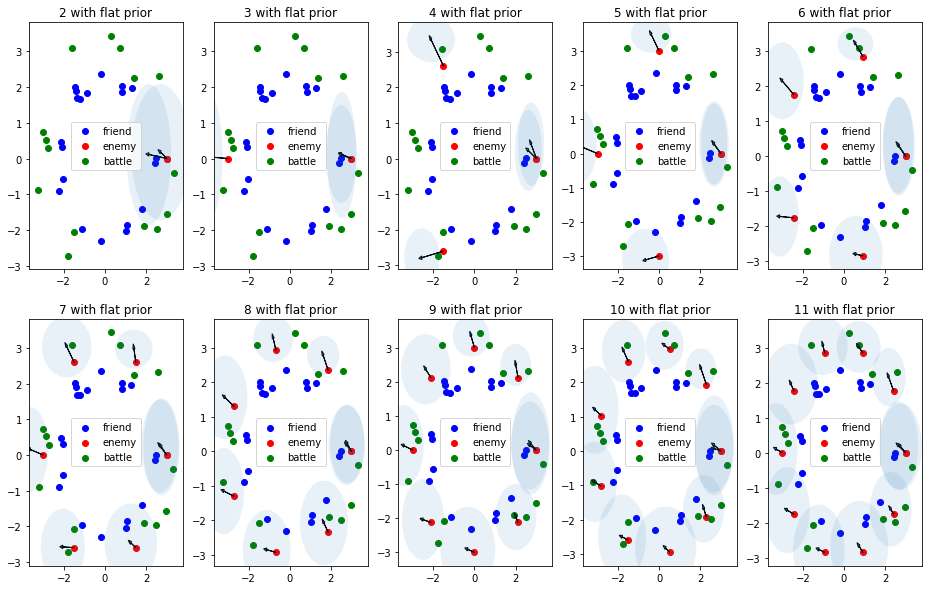

In [13]:
plt.figure(figsize=(16,10))
for i in range(2, 12):
    '''
    interp_x = np.linspace(_enemy_point[:,0].min(),_enemy_point[:,0].max(),i)
    interp_y = np.interp(interp_x, _enemy_point[:,0], _enemy_point[:,1])
    interp_xy = np.c_[interp_x,interp_y]
    '''
    interp_xy = equidistance_init(i)
    plt.subplot(2, 5, i-1)
    multi_enemy_setting_show(interp_xy, target , '{} with flat prior')


In [14]:
def random_init(n):
    return np.random.random(size=(n,2))

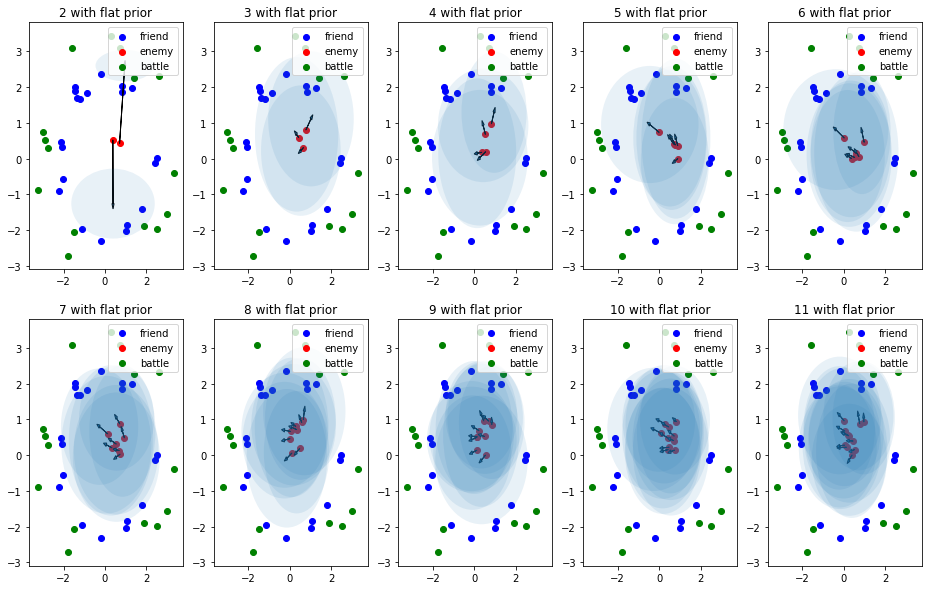

In [15]:
plt.figure(figsize=(16,10))
for i in range(2, 12):
    interp_xy = random_init(i)
    plt.subplot(2, 5, i-1)
    multi_enemy_setting_show(interp_xy, target , '{} with flat prior')


In [16]:
def target2(rad_threshold = 3.0):
    target1 = target()
    
    target2 = target1 + torch.sum(torch.log(soft_cut_ge(torch.sum(enemy**2,dim=1), rad_threshold, tense = 10.0)))
    return target2

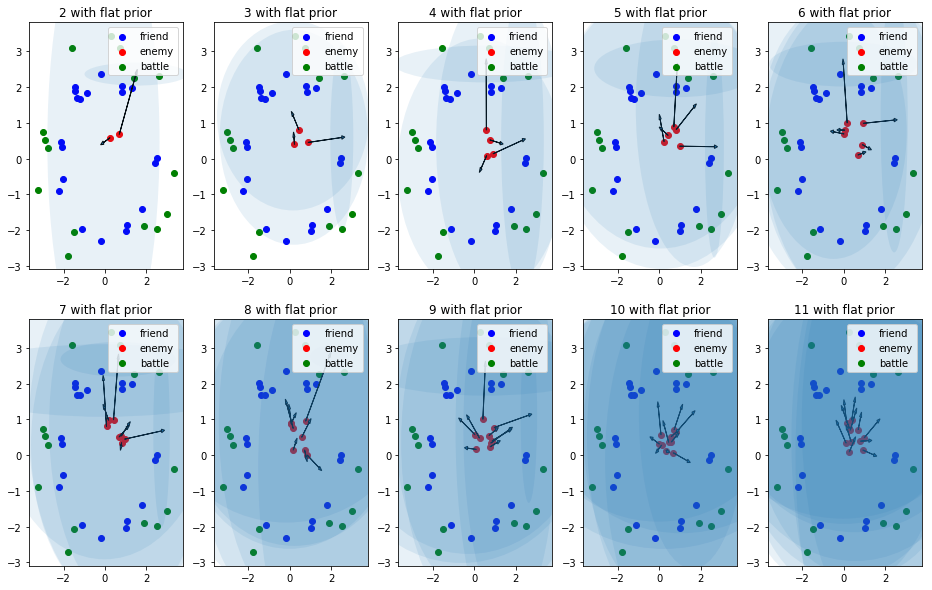

In [17]:
plt.figure(figsize=(16,10))
for i in range(2, 12):
    interp_xy = random_init(i)
    plt.subplot(2, 5, i-1)
    multi_enemy_setting_show(interp_xy, target2 , '{} with flat prior')


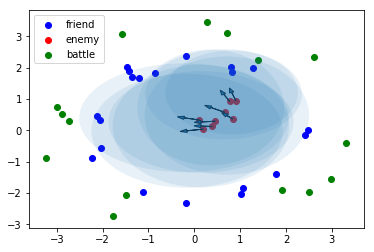

In [18]:
_enemy_point = random_init(8)

reset_enemy(_enemy_point)
res = vb(target)
show_vb(res)
#plt.title(title_string.format(i))
#plt.gca().set_title(title_string.format(i))
plt.legend()
plt.show()

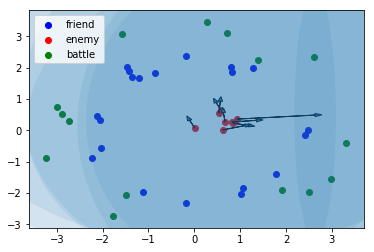

In [19]:
_enemy_point = random_init(8)

reset_enemy(_enemy_point)
res = vb(target2)
show_vb(res)
#plt.title(title_string.format(i))
#plt.gca().set_title(title_string.format(i))
plt.legend()
plt.show()

In [20]:
model.set_parameter(res[0])

In [21]:
model.grad(target2)

array([23.66132927,  1.73187375, 22.17570877,  1.51240027, -2.10810852,
        5.84523201, 11.39710903, 21.3679657 ,  0.44492912,  0.37233031,
       12.75307083, 12.18698025, 27.21092415,  5.79315805,  9.57314491,
       20.324646  ])

In [22]:
report = vb(target2, format=True, n_epoch=10)


In [23]:
report

{'converge': False, 'est': {Variable containing:
   1.7684  0.1200
   1.7316  0.2126
  -0.1766  0.4744
   0.8960  1.4853
   2.8635  0.5089
   1.0678  1.0268
   1.9147  0.5239
   0.5406  1.3168
  [torch.FloatTensor of size 8x2]: {'mu': array([[ 1.76836286,  0.11995336],
          [ 1.73156742,  0.21263956],
          [-0.17656446,  0.47435043],
          [ 0.89602769,  1.48534029],
          [ 2.86349765,  0.50893838],
          [ 1.06783082,  1.0268089 ],
          [ 1.91472271,  0.52391149],
          [ 0.5405647 ,  1.31682181]]),
   'omega': array([[ 0.00848046,  0.69445607],
          [-0.05921574,  0.6263867 ],
          [ 0.60890409,  0.82264197],
          [ 0.35049282,  0.18197555],
          [-0.25696871,  0.22379046],
          [ 0.4154477 ,  0.47037551],
          [-0.18069138,  0.48794819],
          [ 0.60141885,  0.33351516]])}}, 'grad': array([ 6.89949989e+00, -1.70908904e+00,  1.35920658e+01, -1.89528733e-01,
        -3.50242496e+00,  8.52424049e+00,  8.55850983e+00,  1.

In [24]:
vb(target2, format=True, n_epoch=10,reload=True)

{'converge': False, 'est': {Variable containing:
   2.2057  0.1656
   2.2714  0.2354
  -0.3802  0.6391
   1.0601  1.9879
   3.0691  0.5015
   1.5816  1.1632
   2.2795  0.5436
   0.7495  1.8753
  [torch.FloatTensor of size 8x2]: {'mu': array([[ 2.2056697 ,  0.16555793],
          [ 2.2713573 ,  0.23535362],
          [-0.38024628,  0.63906537],
          [ 1.06005286,  1.98790906],
          [ 3.06909349,  0.5015049 ],
          [ 1.58163002,  1.16317648],
          [ 2.27949077,  0.54355399],
          [ 0.74949064,  1.87532841]]),
   'omega': array([[-1.91541461e-01,  3.15146851e-01],
          [-2.77979498e-01,  4.02074316e-01],
          [ 7.25565145e-01,  6.65004093e-01],
          [ 1.97268318e-01, -1.22184215e-01],
          [-2.63880969e-01,  1.80314588e-01],
          [-6.45216683e-04,  4.79786715e-01],
          [-2.12918363e-01,  2.63702458e-01],
          [ 3.75818658e-01, -5.08644623e-02]])}}, 'grad': array([-0.19181103, -2.02010751, -0.19256337, -1.85028088, -7.76711941,
 

In [25]:
vb(target2, format=True, n_epoch=10,reload=True)

{'converge': False, 'est': {Variable containing:
   2.6062  0.1208
   2.5706  0.3483
  -0.4927  0.9303
   1.1156  2.3507
   3.1431  0.5210
   1.8467  1.4350
   2.6840  0.5472
   0.8770  2.3829
  [torch.FloatTensor of size 8x2]: {'mu': array([[ 2.6061565 ,  0.12078153],
          [ 2.57064856,  0.34825204],
          [-0.4927288 ,  0.93032192],
          [ 1.11559181,  2.35070496],
          [ 3.1431337 ,  0.52103982],
          [ 1.84670679,  1.4350059 ],
          [ 2.68396509,  0.5472046 ],
          [ 0.87703082,  2.38286314]]),
   'omega': array([[-0.34130128,  0.25912662],
          [-0.19827851,  0.25397618],
          [ 0.56882239,  0.63006578],
          [ 0.12057034, -0.15046307],
          [-0.08524671,  0.17131947],
          [-0.08480526,  0.1182625 ],
          [-0.35651707,  0.32788279],
          [ 0.25624673, -0.28317356]])}}, 'grad': array([  1.69457173,  -2.93304062,  -0.183002  ,  -1.25284159,
        -10.15386486,  18.13998032,  -0.23026572,   1.44973731,
         -

In [26]:
vb(target2, format=True, n_epoch=100,reload=True)

{'converge': False, 'est': {Variable containing:
   3.0181 -0.2247
   3.0180  0.2267
  -0.6825  1.6504
   0.7384  3.1560
   3.4016  0.2766
   2.7435  2.0354
   3.0065  0.3732
   0.5782  3.2518
  [torch.FloatTensor of size 8x2]: {'mu': array([[ 3.01808161, -0.22467189],
          [ 3.01797647,  0.22667511],
          [-0.68251006,  1.65037306],
          [ 0.73839775,  3.15600914],
          [ 3.40159081,  0.27660028],
          [ 2.74354315,  2.03538558],
          [ 3.00652498,  0.37321316],
          [ 0.57821032,  3.25176997]]),
   'omega': array([[-0.20112571,  1.16834531],
          [-0.10530895,  1.11387206],
          [ 3.43822577,  1.9859067 ],
          [ 0.95320516, -0.29466757],
          [-0.09471959,  1.25072907],
          [-0.28650562,  0.5864867 ],
          [-0.08306111,  1.32358502],
          [ 0.85495435, -0.3734591 ]])}}, 'grad': array([-0.09693827, -0.59646648, -0.10939611, -0.47449264, -2.18466043,
         4.19864607, -0.28978541,  0.26908344, -0.07909302, -0.46

In [27]:
vb(target2, format=True, n_epoch=1000,reload=True)

{'converge': False, 'est': {Variable containing:
   3.2426 -0.8455
   3.2141 -0.3456
  -1.9373  3.1753
  -0.0954  3.5125
   3.2814 -0.1435
   2.5141  2.3757
   3.2939 -0.2485
  -0.3232  3.4901
  [torch.FloatTensor of size 8x2]: {'mu': array([[ 3.24258694, -0.84553732],
          [ 3.21411434, -0.34556776],
          [-1.93733609,  3.17534167],
          [-0.09537276,  3.51246221],
          [ 3.28142435, -0.14349961],
          [ 2.51409753,  2.37567735],
          [ 3.29386095, -0.24854572],
          [-0.32322547,  3.49009062]]),
   'omega': array([[ 6.28552362,  6.45237181],
          [ 6.12763834,  6.14014207],
          [ 6.19318916,  6.36640022],
          [ 6.34520492,  6.24422158],
          [ 6.19124714,  6.36337209],
          [-0.48763239, -0.54805034],
          [ 6.21337785,  6.31547089],
          [ 6.47880762,  6.23501715]])}}, 'grad': array([-0.4526974 , -1.00239325, -0.16724229, -0.18363982, -0.8151089 ,
        -0.01280552,  2.03400278, -1.35287857, -0.15985015, -0.17

In [28]:
vb(target2, format=True, n_epoch=1000,reload=True)

{'converge': False, 'est': {Variable containing:
   3.3774 -1.6722
   3.3256 -0.7605
  -3.8849  3.6164
  -1.0232  3.5910
   3.4301 -0.8311
   1.8831  3.2494
   3.2266 -0.8514
  -1.5990  3.4963
  [torch.FloatTensor of size 8x2]: {'mu': array([[ 3.37744774, -1.67221677],
          [ 3.32556345, -0.76049229],
          [-3.88491561,  3.61639088],
          [-1.02318442,  3.59104093],
          [ 3.43007742, -0.83111297],
          [ 1.88314685,  3.24935977],
          [ 3.22660003, -0.85144642],
          [-1.59898972,  3.49629534]]),
   'omega': array([[6.1945559 , 6.61617856],
          [6.05207292, 6.4138256 ],
          [6.16163296, 6.38238277],
          [6.17815491, 6.45449794],
          [6.08852678, 6.55950796],
          [5.7565963 , 3.74992182],
          [6.16779761, 6.35736456],
          [6.03394749, 6.44822287]])}}, 'grad': array([-0.42598578, -0.39502332, -0.40585339, -0.34991753, -1.18821049,
        -0.19570948, -0.87754273, -0.19670001, -0.39409935, -0.36949125,
        

In [29]:
vb(target2, format=True, n_epoch=1000,reload=True)

{'converge': False, 'est': {Variable containing:
   3.4608 -2.3375
   3.4163 -1.5990
  -5.7313  3.4671
  -2.0675  3.9987
   3.6478 -1.5764
   0.5612  3.4060
   3.5843 -1.3844
  -2.8215  4.0384
  [torch.FloatTensor of size 8x2]: {'mu': array([[ 3.46083948, -2.33752795],
          [ 3.41629441, -1.59902229],
          [-5.73126231,  3.46705295],
          [-2.06752733,  3.99868792],
          [ 3.6478014 , -1.57644275],
          [ 0.56124389,  3.406023  ],
          [ 3.58427767, -1.38439224],
          [-2.82151284,  4.03843278]]),
   'omega': array([[5.4709059 , 5.74425646],
          [5.46142443, 5.50161982],
          [5.55312975, 5.69726624],
          [5.42031791, 5.58161833],
          [5.40435097, 5.67836629],
          [5.37595752, 5.01499207],
          [5.25025957, 5.6251018 ],
          [5.3834397 , 5.67793334]])}}, 'grad': array([-0.35642129, -0.23893946, -0.39207497, -0.22558984, -0.52505505,
        -0.15758064,  2.32188201, -5.41192675, -0.3529914 , -0.22827186,
        

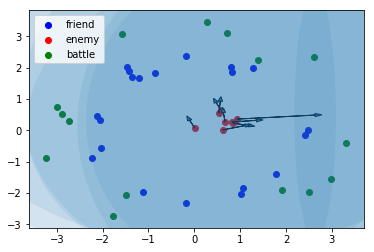

In [30]:
show_vb(res)
#plt.title(title_string.format(i))
#plt.gca().set_title(title_string.format(i))
plt.legend()
plt.show()

In [31]:
_enemy_point = random_init(8)

reset_enemy(_enemy_point)


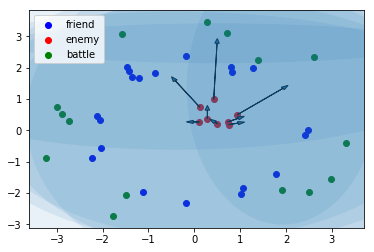

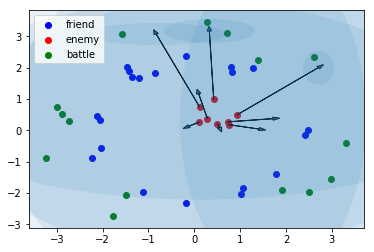

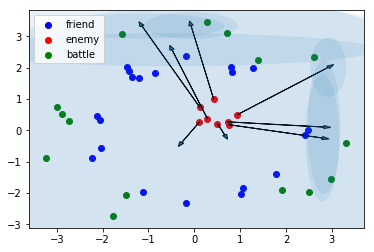

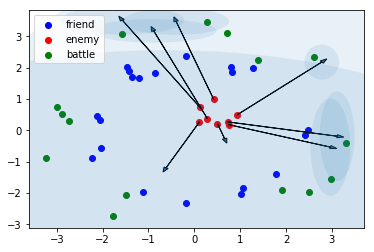

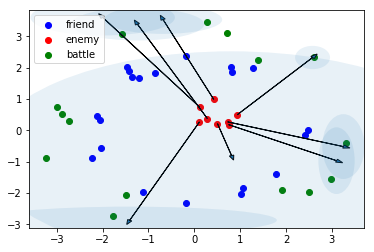

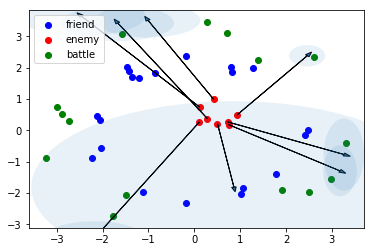

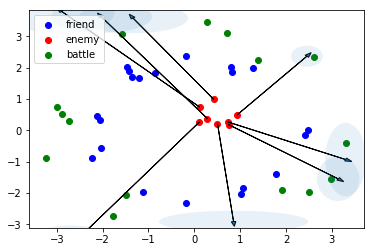

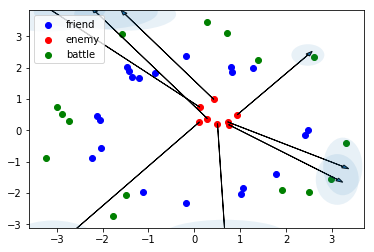

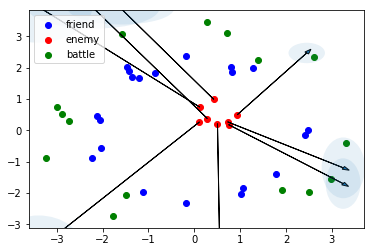

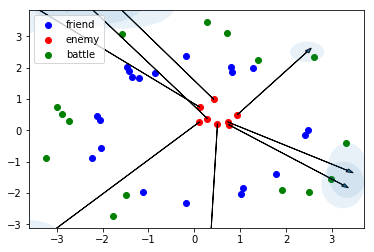

In [32]:
for i in range(10):
    res = vb(target2, n_epoch=100)
    show_vb(res)
    plt.legend()
    plt.show()
    model.set_parameter(res[0])

In [33]:
_enemy_point = random_init(8)

reset_enemy(_enemy_point)


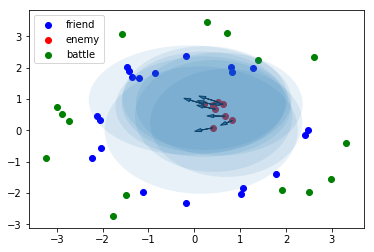

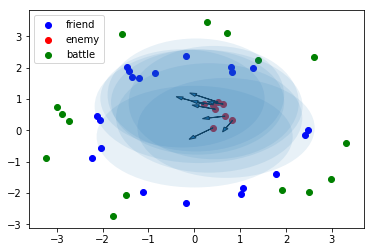

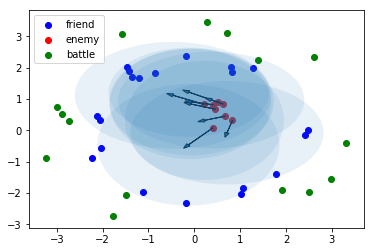

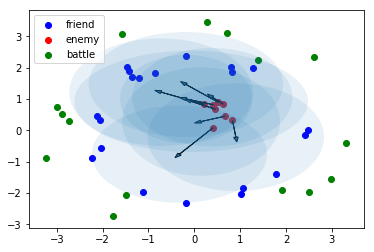

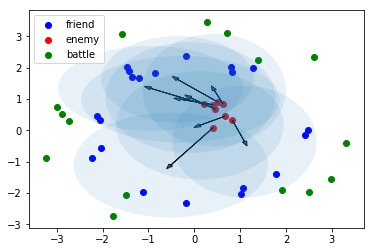

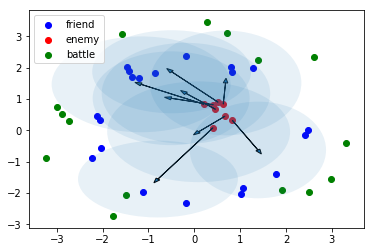

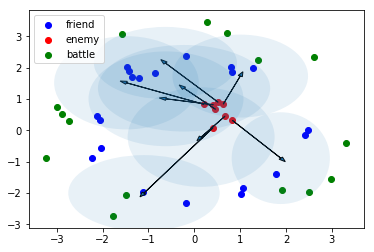

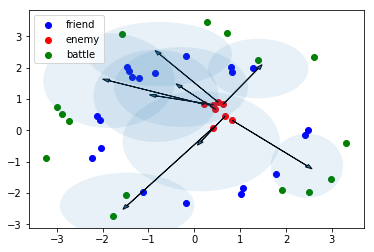

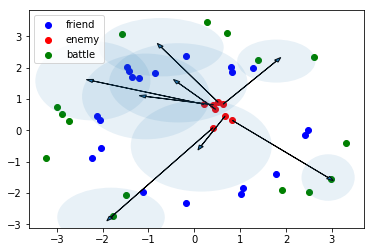

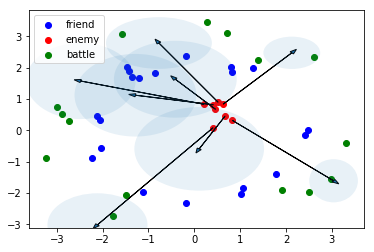

In [34]:
for i in range(10):
    res = vb(target, n_epoch=100)
    show_vb(res)
    plt.legend()
    plt.show()
    model.set_parameter(res[0])

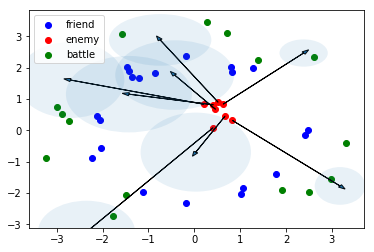

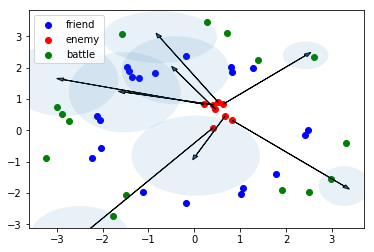

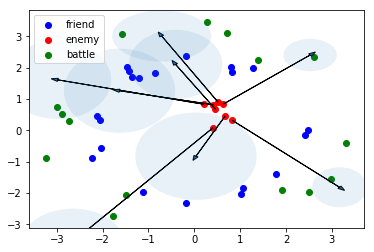

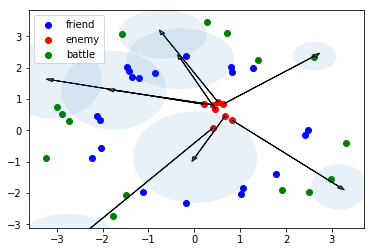

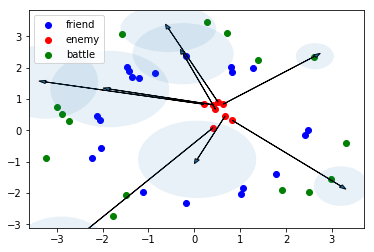

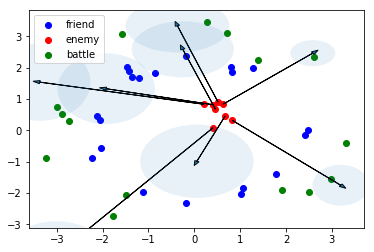

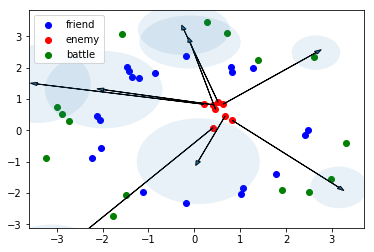

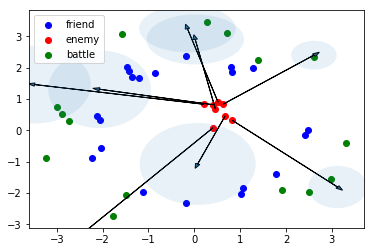

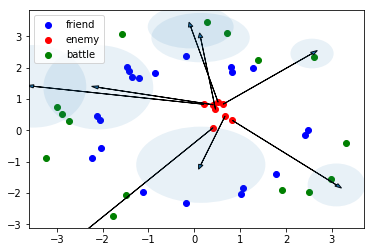

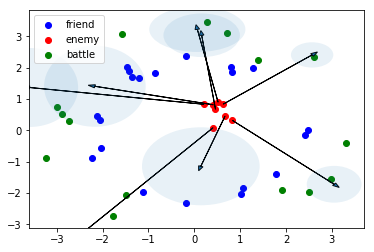

In [35]:
for i in range(10):
    res = vb(target, n_epoch=100)
    show_vb(res)
    plt.legend()
    plt.show()
    model.set_parameter(res[0])

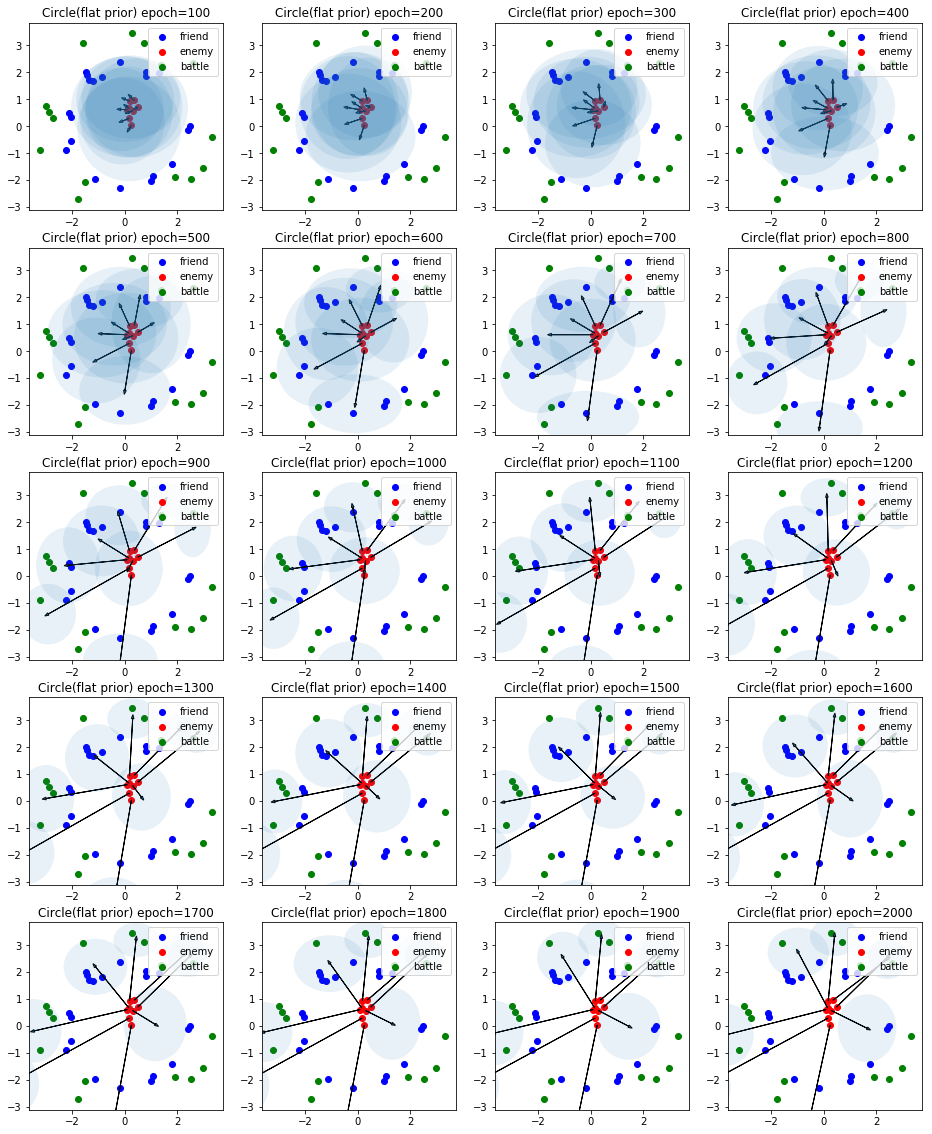

In [38]:
_enemy_point = random_init(8)
reset_enemy(_enemy_point)

plt.figure(figsize=(16,20))

for i in range(20):
    res = vb(target, n_epoch=100)
    plt.subplot(5,4,i+1)
    show_vb(res)
    plt.legend()
    plt.gca().set_title('Circle(flat prior) epoch={}'.format((i+1)*100))
    #plt.show()
    model.set_parameter(res[0])
plt.show()